### Adversarial Discriminative Domain Adaptation

In [1]:
# import modules and libraries
import torch
import torch.nn as nn
from torch.optim import Adam

# functions to create datasets and models
from data.data import *
from models.models import *
from models.losses import MMDLoss, CORAL

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available')
    device = torch.device('cuda')

CUDA is available


### Parameters

In [3]:
"""Parameters for this experiment"""
# params for loading the data
path = 'data/Paderborn_FD/'
source_domain = 'a'
target_domains = ['b', 'c', 'd']

# params for configuring the model
input_dim = 1
hidden_dim = 256
output_dim = 3
drop_prob = 0.5

# params for training the model
epochs_pre = 20 # pre-training
epochs = 20

# optimizing the model
lr = 1e-4
batch_size = 20
beta1 = 0.5
beta2 = 0.9
lambda_rpy = 0.03

### Data Loading

In [4]:
# source domain data for training, validating and testing
train_dataloader_src, val_dataloader_src, test_dataloader_src = generate_dataloaders(path, source_domain, batch_size)

# target domain data for validating and testing
train_dataloader_tgt, val_dataloader_tgt, test_dataloader_tgt = [], [], []
for target_domain in target_domains:
    train_dataloader_temp, val_dataloader_temp, test_dataloader_temp = generate_dataloaders(path, target_domain, batch_size)
    
    train_dataloader_tgt.append(train_dataloader_temp)
    val_dataloader_tgt.append(val_dataloader_temp)
    test_dataloader_tgt.append(test_dataloader_temp)

# replay data for CDA
replay_dataset = ReplayDataset(train_dataloader_src.dataset)
replay_dataloader = DataLoader(dataset=replay_dataset, batch_size=batch_size)

### Model

In [5]:
encoder_src = Encoder_AMDA(
    input_dim=input_dim, # 1D input (sensor readings)
    hidden_dim=hidden_dim # hidden layers 64
)

classifier = Classifier_AMDA(
    hidden_dim=hidden_dim, # hidden layers 64
    output_dim=output_dim, # 3 classes (healthy, inner- and outer-bearing damages)
    dropout=drop_prob # dropout prob 0.5
)

encoder_tgt_mmd = Encoder_AMDA(
    input_dim=input_dim, # 1D input (sensor readings)
    hidden_dim=hidden_dim, # hidden layers 64
)

encoder_tgt_coral = Encoder_AMDA(
    input_dim=input_dim, # 1D input (sensor readings)
    hidden_dim=hidden_dim, # hidden layers 64
)

if train_on_gpu:
    encoder_src = encoder_src.to(device)
    classifier = classifier.to(device)
    encoder_tgt_mmd = encoder_tgt_mmd.to(device)
    encoder_tgt_coral = encoder_tgt_coral.to(device)

#### Functions for training and testing the model

In [6]:
# functions for training source encoder and shared classifier
def train_src(encoder, classifier):
    """Train the source encoder and shared classifier on source domain"""
    encoder.train()
    classifier.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(
        list(encoder.parameters()) + list(classifier.parameters()),
        lr=lr,
        betas=(beta1, beta2)
    )

    for epoch in range(epochs_pre):
        accuracies = []
        losses = []

        for batch_idx, (x_src, y_src) in enumerate(train_dataloader_src):
            if train_on_gpu:
                x_src, y_src = x_src.to(device), y_src.to(device)

            optimizer.zero_grad()

            e_src = encoder(x_src)
            pred_src = classifier(e_src)
            loss_src = criterion(pred_src, y_src)
            loss_src.backward()

            optimizer.step()

            losses.append(loss_src.detach().item()) # detach the loss from compute graph 
            accuracies.append(y_src.eq(pred_src.detach().argmax(dim=1)).float().mean())
        
        # print for each epoch
        print(f'Epoch: {epoch + 1} \n \t Train Loss:{torch.tensor(losses).mean():0.2f} \t Train Acc:{torch.tensor(accuracies).mean():0.2f}')

        # for each epoch, evaluate your model on the validation data
        val_loss, val_acc = evaluate_src(encoder, classifier, phase = 'Val')
        print(f'\t Val Loss:{val_loss:0.2f} \t\t Val Acc:{val_acc:0.2f}')

    return encoder, classifier

# testing model on source domain
def evaluate_src(encoder, classifier, phase='Val'): # phase can be validate or test
    """Evaluate the trained network on source domain"""
    encoder.eval()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    dataloader = val_dataloader_src if phase == 'Val' else test_dataloader_src
    
    with torch.no_grad():
        for batch_idx, (x_src, y_src) in enumerate(dataloader):
            if train_on_gpu:
                x_src, y_src = x_src.to(device), y_src.to(device)

            e_src = encoder(x_src)
            pred_src = classifier(e_src)
            loss_src = criterion(pred_src, y_src)
            
            # append loss for each batch
            losses.append(loss_src.detach().item()) # detach the loss from compute graph 
            accuracies.append(y_src.eq(pred_src.detach().argmax(dim=1)).float().mean())
            
        mean_loss = torch.tensor(losses).mean()
        mean_acc = torch.tensor(accuracies).mean()
        return mean_loss, mean_acc

In [7]:
# Continuous Unsupervised Adaptation (CUA)
# functions for training target encoder
def train_tgt(encoder_src, encoder_tgt, classifier, loss_function, phase):
    """Train the target encoder on target domains with source encoder and test the network"""
    encoder_tgt.train()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    if loss_function == "CORAL":
        f_criterion = CORAL()
        optimizer = Adam(
            encoder_tgt.parameters(),
            lr=lr,
            betas=(beta1, beta2)
        )
    else: # MMD
        f_criterion = MMDLoss()
        optimizer = Adam(
            encoder_tgt.parameters(),
            lr=lr,
            betas=(beta1, beta2)
        )

    for epoch in range(epochs):
        losses = []
        losses_tgt = []
        losses_rpy = []
        accuracies = []

        for batch_idx, ((x_src, y_src), (x_tgt, y_tgt), (x_rpy, y_rpy)) in enumerate(zip(train_dataloader_src, train_dataloader_tgt[phase], replay_dataloader)):
            if(train_on_gpu):
                x_src, y_src = x_src.to(device), y_src.to(device)
                x_tgt, y_tgt = x_tgt.to(device), y_tgt.to(device)
                x_rpy, y_rpy = x_rpy.to(device), y_rpy.to(device)

            optimizer.zero_grad()

            # part 1: sequential unsupervised adaptation
            # learn e_src and _tgt: source and target mapping represenations
            e_src = encoder_src(x_src)
            e_tgt = encoder_tgt(x_tgt)
            # minimize distance between source and target empirical mapping distribution using adversarial discriminator
            pred_tgt = classifier(e_tgt)
            loss_tgt = f_criterion(e_src, e_tgt)
            if loss_function != "CORAL": # MMD
                loss.requires_grad_()

            # part 2: continuous replay adaptation
            # additional replay loss to retain 'prior knowledge'
            pred_rpy = classifier(encoder_tgt(x_rpy))
            loss_rpy = criterion(pred_rpy, y_rpy)
            loss = loss_tgt + lambda_rpy * loss_rpy

            loss.backward()

            optimizer.step()
            
            # training (with replay) losses and accuracies
            losses.append(loss.detach().item()) # detach the loss from compute graph
            losses_tgt.append(loss_tgt.detach().item())
            losses_rpy.append(loss_rpy.detach().item())
            accuracies.append(y_tgt.eq(pred_tgt.detach().argmax(dim=1)).float().mean())
        
        # print for each epoch
        print(f'Epoch: {epoch + 1} \n \t Train Loss:{torch.tensor(losses).mean():0.2f} \t Train Acc:{torch.tensor(accuracies).mean():0.2f}')
        print(f'\t Train ({loss_function}) Loss:{torch.tensor(losses_tgt).mean():0.2f} \t Train (Replay) Loss:{torch.tensor(losses_rpy).mean():0.2f}')
        # for each epoch, evaluate your model on the validation data
        val_loss, val_acc = evaluate_tgt(encoder_tgt, classifier, val_dataloader_tgt[phase])
        print(f'\t Val (with Target) Loss:{val_loss:0.2f} \t Val (with Target) Acc:{val_acc:0.2f}')

    return encoder_tgt
    
# testing model on target domains
def evaluate_tgt(encoder, classifier, dataloader):
    """Evaluate the network on current target domain"""
    encoder.eval()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(dataloader): # target dataloader
            if(train_on_gpu):
                x, y = x.to(device), y.to(device)

            pred_tgt = classifier(encoder(x))
            loss_tgt = criterion(pred_tgt, y)
            
            # append loss for each batch
            losses.append(loss_tgt.detach().item()) # detach the loss from compute graph 
            accuracies.append(y.eq(pred_tgt.detach().argmax(dim=1)).float().mean())
            
        mean_loss = torch.tensor(losses).mean()
        mean_acc = torch.tensor(accuracies).mean()
        return mean_loss, mean_acc

In [8]:
# subsample previously seen examples and their respective classification scores as 'soft labels' from the target domains
def generate_data_tuple(encoder_tgt, classifier, dataloader):
    print('===> generate new replay dataset!')
    encoder_tgt.eval()
    classifier.eval()

    all_x, all_pred = [], []
    for batch_idx, (x_tgt, y_tgt) in enumerate(dataloader):
        if(train_on_gpu):
            x_tgt, y_tgt = x_tgt.to(device), y_tgt.to(device)

        # perform classification with the target mapping representations
        pred_tgt = classifier(encoder_tgt(x_tgt))

        all_x.append(to_np(x_tgt))
        all_pred.append(to_np(pred_tgt.detach().argmax(dim=1)))
        
    x, pred = np.concatenate(all_x, 0), np.concatenate(all_pred, 0)
    print('generated: ', x.shape, pred.shape)
    return x, pred

### Pre-training

In [9]:
# pre-training
# encoder_src, classifier = train_src(encoder_src, classifier)
# torch.save(encoder_src.state_dict(), './dump/source_encoder.pt')
# torch.save(classifier.state_dict(), './dump/classifier.pt')
encoder_src.load_state_dict(torch.load('./dump/source_encoder.pt'))
classifier.load_state_dict(torch.load('./dump/classifier.pt'))

<All keys matched successfully>

In [10]:
encoder_tgt_coral.load_state_dict(encoder_src.state_dict())

# adaptation
for phase in range(len(target_domains)):
    if(phase == 0): # Domain A to B
        print(f'\nPhase {phase + 1} (Domain {source_domain} to Domain {target_domains[phase]})')
    else: # Domain B to C, and Domain C to D
        print(f'\nPhase {phase + 1} (Domain {target_domains[phase - 1]} to Domain {target_domains[phase]})')
    
    encoder_tgt_coral = train_tgt(encoder_src, encoder_tgt_coral, classifier, "CORAL", phase)
    
    print('\nTesting Accuracy on Previously Seen and Current Domains:')
    print(f'Source Domain {source_domain}:')
    src_test_loss, src_test_acc = evaluate_src(encoder_tgt_coral, classifier, phase='Test')
    print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 
    for p in range(phase + 1):
        print(f'Target Domain {target_domains[p]}:')
        tgt_test_loss, tgt_test_acc = evaluate_tgt(encoder_tgt_coral, classifier, test_dataloader_tgt[p])
        print(f'\t Test (with Target) Loss:{tgt_test_loss:0.2f} \t Test (with Target) Acc:{tgt_test_acc:0.2f}')

    # update replay data and dataloader
    data_tuple = generate_data_tuple(encoder_tgt_coral, classifier, train_dataloader_tgt[phase])
    replay_dataset.replay_dataset.update(data_tuple)
    print(replay_dataset.__len__())
    replay_dataloader = DataLoader(dataset=replay_dataset, batch_size=batch_size)


Phase 1 (Domain a to Domain b)
Epoch: 1 
 	 Train Loss:0.13 	 Train Acc:0.53
	 Train (CORAL) Loss:0.13 	 Train (Replay) Loss:0.08
	 Val (with Target) Loss:10.48 	 Val (with Target) Acc:0.55
Epoch: 2 
 	 Train Loss:0.08 	 Train Acc:0.55
	 Train (CORAL) Loss:0.08 	 Train (Replay) Loss:0.04
	 Val (with Target) Loss:6.57 	 Val (with Target) Acc:0.66
Epoch: 3 
 	 Train Loss:0.08 	 Train Acc:0.64
	 Train (CORAL) Loss:0.07 	 Train (Replay) Loss:0.06
	 Val (with Target) Loss:8.66 	 Val (with Target) Acc:0.63
Epoch: 4 
 	 Train Loss:0.06 	 Train Acc:0.66
	 Train (CORAL) Loss:0.06 	 Train (Replay) Loss:0.05
	 Val (with Target) Loss:4.62 	 Val (with Target) Acc:0.65
Epoch: 5 
 	 Train Loss:0.06 	 Train Acc:0.63
	 Train (CORAL) Loss:0.06 	 Train (Replay) Loss:0.04
	 Val (with Target) Loss:5.84 	 Val (with Target) Acc:0.63
Epoch: 6 
 	 Train Loss:0.06 	 Train Acc:0.62
	 Train (CORAL) Loss:0.06 	 Train (Replay) Loss:0.04
	 Val (with Target) Loss:5.35 	 Val (with Target) Acc:0.62
Epoch: 7 
 	 Train 

	 Test (with Source) Loss:0.03 	 Test (with Source) Acc:0.99

Phase 1 (Domain a to Domain b)
	 Test (with Target) Loss:8.46 	 Test (with Target) Acc:0.52

Phase 2 (Domain b to Domain c)
	 Test (with Target) Loss:5.18 	 Test (with Target) Acc:0.61

Phase 3 (Domain c to Domain d)
	 Test (with Target) Loss:6.10 	 Test (with Target) Acc:0.57


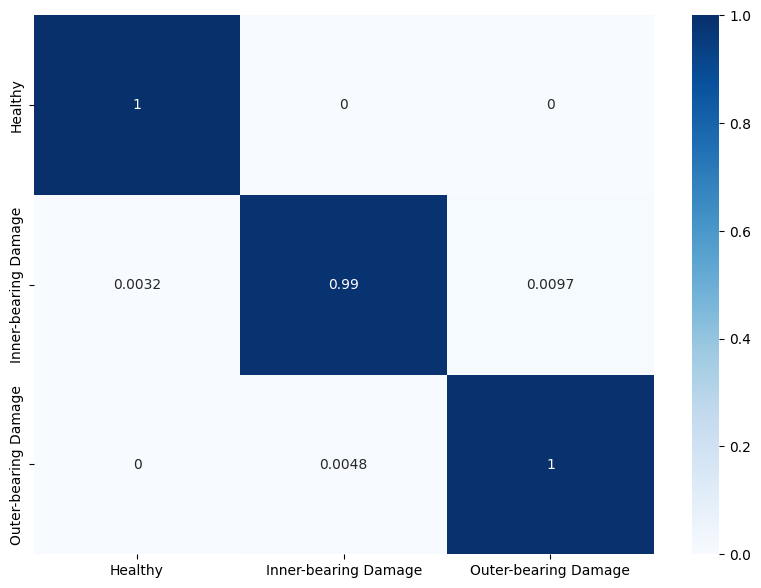

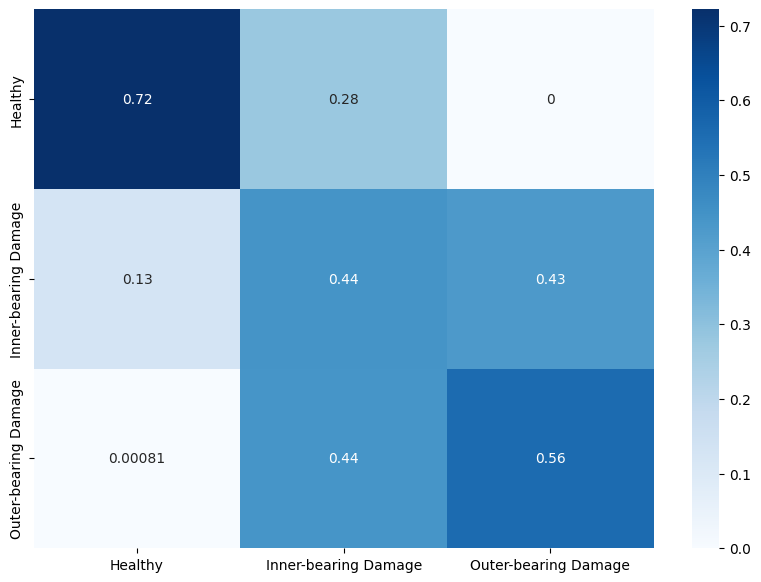

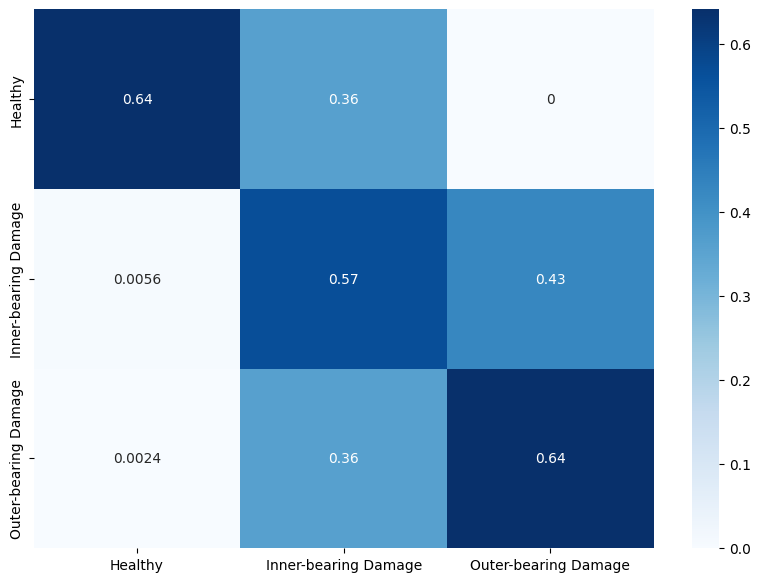

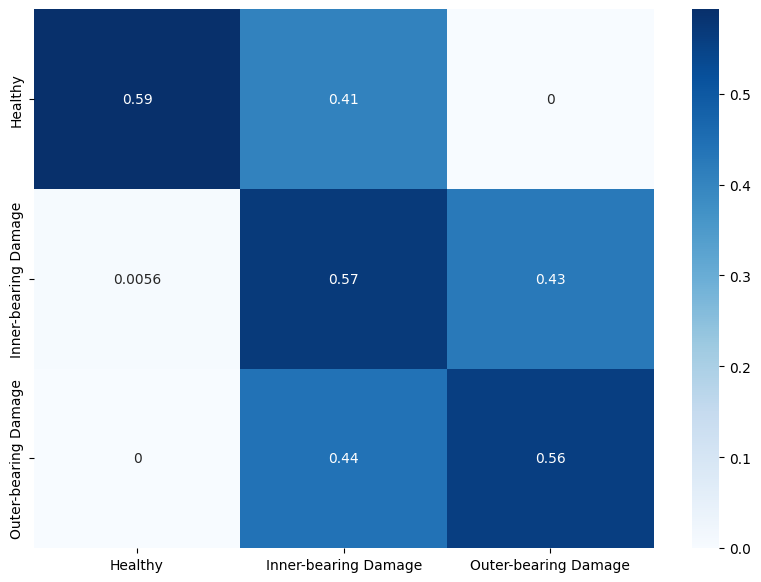

In [11]:
generate_confusion_matrix(encoder_tgt_coral, classifier, test_dataloader_src, "cuda")
src_test_loss, src_test_acc = evaluate_src(encoder_tgt_coral, classifier, phase='Test')
print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 
for phase in range(len(target_domains)):
    if(phase == 0): # Domain A to B
        print(f'\nPhase {phase + 1} (Domain {source_domain} to Domain {target_domains[phase]})')
    else: # Domain B to C, and Domain C to D
        print(f'\nPhase {phase + 1} (Domain {target_domains[phase - 1]} to Domain {target_domains[phase]})')
    
    generate_confusion_matrix(encoder_tgt_coral, classifier, test_dataloader_tgt[phase], "cuda")
    tgt_test_loss, tgt_test_acc = evaluate_tgt(encoder_tgt_coral, classifier, test_dataloader_tgt[phase])
    print(f'\t Test (with Target) Loss:{tgt_test_loss:0.2f} \t Test (with Target) Acc:{tgt_test_acc:0.2f}') 